In [1]:
import mlflow
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, Trials, STATUS_OK, hp, space_eval
from functools import partial

from pickle import dump

from scripts.Preprocessing import Preprocessing
from scripts.BinaryClassificationTraining import BinaryClassificationTraining

from scripts.config import (year_month_train, 
    input_data_path_train,
    seed)

In [2]:
local_path_save = './local_artifacts_tmp/04_Logistic_Regression/'
year_month = year_month_train
input_data_path = input_data_path_train

### MLFlow setting

In [3]:
if not os.path.exists(local_path_save):
    os.makedirs(local_path_save)

#save all metadata in a sqlite db. Artifacts will be saved on local folder ./mlflow    
mlflow.set_tracking_uri("sqlite:///mlflow.db")

# Name of the experiment
exp_name = "04 - Logistic Regression"
# set up MlFlow axperiment
experiment_id = mlflow.set_experiment(exp_name)

### Experiments

In [9]:
run_name = 'single_run'

In [10]:
logistic_regression_training = BinaryClassificationTraining(
    input_data_path,
    local_path_save,
    year_month,
    'logistic_regression')

In [11]:
prepr = Preprocessing(input_data_path_train, task_type='classification')
X, Y = prepr.read_dataframe(request_tgt=True)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=seed)


#preprocessing ohe
shapes_pre = (X_train.shape[0], X_test.shape[0])
X_train_ohe, ohe, scaler = prepr.preprocess_for_classification(df=X_train, fit_ohe=True, perform_scaling=True)
X_test_ohe, _, _ = prepr.preprocess_for_classification(df=X_test, 
                                                    fit_ohe=False, 
                                                    ohe=ohe,
                                                    perform_scaling=True,
                                                    scaler=scaler)
assert shapes_pre == (X_train.shape[0], X_test.shape[0])
dump(ohe, open(local_path_save + run_name + '_ohe.pkl', 'wb'))
dump(scaler, open(local_path_save + run_name + '_scaler.pkl', 'wb'))

/Users/davideposillipo/Documents/Didattica.nosync/DSR_ML_Fundamentals_2023/scripts/Preprocessing.py:161: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['lpep_pickup_datetime_week'] = df['lpep_pickup_datetime'].dt.week
/Users/davideposillipo/Documents/Didattica.nosync/DSR_ML_Fundamentals_2023/scripts/Preprocessing.py:161: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['lpep_pickup_datetime_week'] = df['lpep_pickup_datetime'].dt.week


In [13]:
# Calculating the baseline
logistic_regression_training.calculate_classification_baseline(Y_train=Y_train, Y_test=Y_test, run_name=run_name)

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.5, 'status': 'ok'}

In [14]:
max_evals = 1

# Here we can decide which hyperparameters we want to tune
logistic_regression_parameters_search = {
    #'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', None]),
    'penalty': 'l2',
    #'C': hp.lognormal('C', -1, 0.5),
    'C': hp.choice('C', [0.4895544602607385]),
    'random_state': seed,
    'max_iter': 500
}

logistic_regression_training.set_hyperparameter_space(logistic_regression_parameters_search)



In [15]:
trials = Trials()

best_result = fmin(
    fn=partial(logistic_regression_training.objective_logistic_regression, 
        X_train=X_train_ohe,
        X_test=X_test_ohe,
        Y_train=Y_train,
        Y_test=Y_test,
        run_name=run_name,
        threshold=0.5),
    space=logistic_regression_training.hp_space,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    rstate=np.random.default_rng(seed)
)

best_result

100%|██████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.16s/trial, best loss: 0.7355874080446025]


/Users/davideposillipo/.pyenv/versions/3.10.9/envs/mlops/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")



{'C': 0}

### Learning Curve of the best model

In [39]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer

In [40]:
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [41]:
best_hps = logistic_regression_parameters_search.copy()
best_hps['C'] = 0.9

In [42]:
best_hps

{'penalty': 'l2', 'C': 0.9, 'random_state': 123, 'max_iter': 250}

In [43]:
best_logistic_regression = LogisticRegression(**best_hps)

In [44]:
train_sizes, train_scores, test_scores = learning_curve(estimator=best_logistic_regression, X=X_train_ohe, y=Y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=-1,
                                                       scoring=roc_auc_scorer)

/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/davideposillipo/.pyenv/versions/3.10.9/envs/prova/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    h

In [45]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

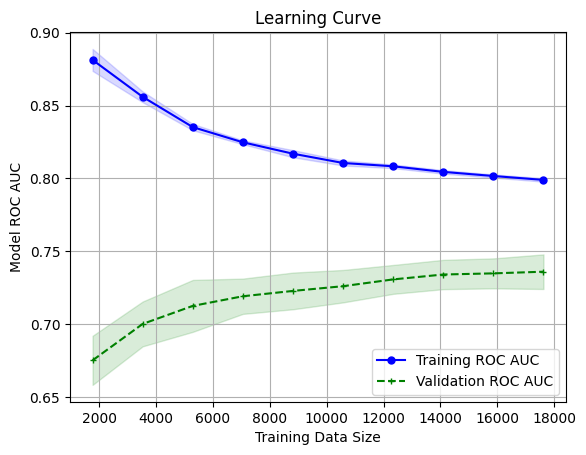

In [46]:
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training ROC AUC')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation ROC AUC')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model ROC AUC')
plt.grid()
plt.legend(loc='lower right')
plt.show()